![Illustration of silhouetted heads](mentalhealth.jpg)

Does going to university in a different country affect your mental health? A Japanese international university surveyed its students in 2018 and published a study the following year that was approved by several ethical and regulatory boards.

The study found that international students have a higher risk of mental health difficulties than the general population, and that social connectedness (belonging to a social group) and acculturative stress (stress associated with joining a new culture) are predictive of depression.


Explore the `students` data using PostgreSQL to find out if you would come to a similar conclusion for international students and see if the length of stay is a contributing factor.

Here is a data description of the columns you may find helpful.

| Field Name    | Description                                      |
| ------------- | ------------------------------------------------ |
| `inter_dom`     | Types of students (international or domestic)   |
| `japanese_cate` | Japanese language proficiency                    |
| `english_cate`  | English language proficiency                     |
| `academic`      | Current academic level (undergraduate or graduate) |
| `age`           | Current age of student                           |
| `stay`          | Current length of stay in years                  |
| `todep`         | Total score of depression (PHQ-9 test)           |
| `tosc`          | Total score of social connectedness (SCS test)   |
| `toas`          | Total score of acculturative stress (ASISS test) |

In [1]:
import pandas as pd
import sqlite3

In [2]:
students = pd.read_csv('students.csv')

In [3]:
conn = sqlite3.connect(':memory:')
cur = conn.cursor()

In [4]:
# Load the DataFrame into the SQLite database
students.to_sql('students', conn, index=False, if_exists='replace')

286

In [5]:
q1 = """
SELECT *
FROM students;
"""

result = pd.read_sql(q1, conn)

In [6]:
print(result)

    inter_dom region  gender academic   age  age_cate  stay stay_cate  \
0       Inter    SEA    Male     Grad  24.0       4.0   5.0      Long   
1       Inter    SEA    Male     Grad  28.0       5.0   1.0     Short   
2       Inter    SEA    Male     Grad  25.0       4.0   6.0      Long   
3       Inter     EA  Female     Grad  29.0       5.0   1.0     Short   
4       Inter     EA  Female     Grad  28.0       5.0   1.0     Short   
..        ...    ...     ...      ...   ...       ...   ...       ...   
281      None   None    None     None   NaN       NaN   NaN      None   
282      None   None    None     None   NaN       NaN   NaN      None   
283      None   None    None     None   NaN       NaN   NaN      None   
284      None   None    None     None   NaN       NaN   NaN      None   
285      None   None    None     None   NaN       NaN   NaN      None   

     japanese japanese_cate  ...  friends_bi parents_bi relative_bi  \
0         3.0       Average  ...         Yes        

The answer we are trying to prove is that international students have a higher risk of mental health difficulties that the general population in Japan. We are also trying to prove the social connectedness and acculturative stress are predictive of depression.

<!-- The key columns that we will focus on is:
- **inter_dom**
- **stay**
- **todep**
- **tosc**
- **toas** -->

### Missing values in our data

#### Check for missing values

In [7]:
q2 = """ 
SELECT 
    SUM(CASE WHEN inter_dom IS NULL THEN 1 ELSE 0 END) AS inter_dom_missing,
    SUM(CASE WHEN academic IS NULL THEN 1 ELSE 0 END) AS academic_missing,
    SUM(CASE WHEN age IS NULL THEN 1 ELSE 0 END) AS age_missing,
    SUM(CASE WHEN english_cate IS NULL THEN 1 ELSE 0 END) AS english_cate_missing,
    SUM(CASE WHEN japanese_cate IS NULL THEN 1 ELSE 0 END) AS japanese_cate_missing,
    SUM(CASE WHEN stay IS NULL THEN 1 ELSE 0 END) AS stay_missing,
    SUM(CASE WHEN todep IS NULL THEN 1 ELSE 0 END) AS todep_missing,
    SUM(CASE WHEN tosc IS NULL THEN 1 ELSE 0 END) AS tosc_missing,
    SUM(CASE WHEN toas IS NULL THEN 1 ELSE 0 END) AS toas_missing
FROM students;
"""

result = pd.read_sql(q2, conn)

print(result)

   inter_dom_missing  academic_missing  age_missing  english_cate_missing  \
0                 18                18           18                    18   

   japanese_cate_missing  stay_missing  todep_missing  tosc_missing  \
0                     18            18             18            18   

   toas_missing  
0            18  


In [8]:
# Each key column we are focusing has 18 missing values

#### Handling missing values
We will handle the missing values by removing them from the dataset. Since the dataset is large enough, removing the missing values will not affect the analysis.

In [9]:
q3 = """
DELETE FROM students
WHERE inter_dom IS NULL OR
        academic IS NULL OR
        age IS NULL OR
        english_cate IS NULL OR
        japanese_cate IS NULL OR
        stay IS NULL OR
        todep IS NULL OR
        tosc IS NULL OR
        toas IS NULL;
"""

cur.execute(q3)

In [10]:
## Check that the missing values have been removed
q4 = """
SELECT 
    SUM(CASE WHEN inter_dom IS NULL THEN 1 ELSE 0 END) AS inter_dom_missing,
    SUM(CASE WHEN academic IS NULL THEN 1 ELSE 0 END) AS academic_missing,
    SUM(CASE WHEN age IS NULL THEN 1 ELSE 0 END) AS age_missing,
    SUM(CASE WHEN english_cate IS NULL THEN 1 ELSE 0 END) AS english_cate_missing,
    SUM(CASE WHEN japanese_cate IS NULL THEN 1 ELSE 0 END) AS japanese_cate_missing,
    SUM(CASE WHEN stay IS NULL THEN 1 ELSE 0 END) AS stay_missing,
    SUM(CASE WHEN todep IS NULL THEN 1 ELSE 0 END) AS todep_missing,
    SUM(CASE WHEN tosc IS NULL THEN 1 ELSE 0 END) AS tosc_missing,
    SUM(CASE WHEN toas IS NULL THEN 1 ELSE 0 END) AS toas_missing
FROM students;
"""

result = pd.read_sql(q4, conn)

print(result)

   inter_dom_missing  academic_missing  age_missing  english_cate_missing  \
0                  0                 0            0                     0   

   japanese_cate_missing  stay_missing  todep_missing  tosc_missing  \
0                      0             0              0             0   

   toas_missing  
0             0  


In [19]:
q5 = """
SELECT 
    stay,
    COUNT(*) AS count_international_students,
    ROUND(AVG(todep), 2) AS avg_depression,
    ROUND(AVG(tosc), 2) AS avg_social_connectedness,
    ROUND(AVG(toas), 2) AS avg_acculturative_stress
FROM students
WHERE inter_dom = 'Inter'
GROUP BY stay
ORDER BY stay;
"""

result = pd.read_sql(q5, conn)

result

,stay,count_international_students,avg_depression,avg_social_connectedness,avg_acculturative_stress
0,1.0,95,7.48,38.11,72.80
1,2.0,39,8.28,37.08,77.67
2,3.0,46,9.09,37.13,78.00
3,4.0,14,8.57,33.93,87.71
4,5.0,1,0.00,34.00,91.00
5,6.0,3,6.00,38.00,58.67
6,7.0,1,4.00,48.00,45.00
7,8.0,1,10.00,44.00,65.00
8,10.0,1,13.00,32.00,50.00


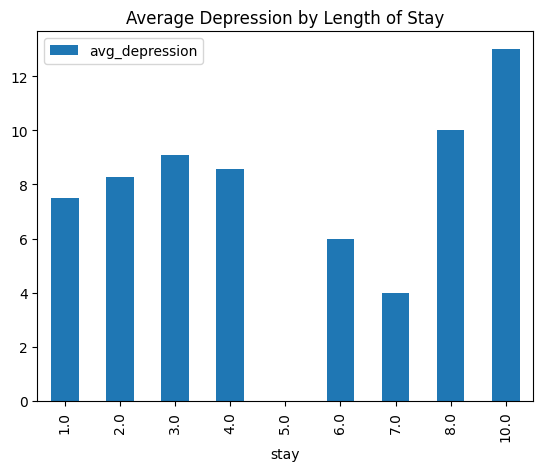

In [20]:
# Plotting the results
import matplotlib.pyplot as plt
result.plot(x='stay', y='avg_depression', kind='bar', title='Average Depression by Length of Stay')
plt.show()

- **General Trend**: The bar chart shows fluctuating levels of average depression based on the length of stay.
- **Notable Observations**: 
    - Depressions seems to be highest at 10.0 years of stay.
    - There is a dip around 6 - 7 year mark, with depression being lowest at around 7 years of stay.
    - The values for 1.0, 2.0, 3.0, 4.0 years of stay are quite similar hovering around the middle of the range.
- **Interpretation**: The data shows that depression levels rise for people who have stayed longer but may decrease around 6-7 years of stay. This could indicate that mental health challenges peak either in the initial phase or in the very long term, while there might be a period of adaption and lower depression around 7.0 years. 

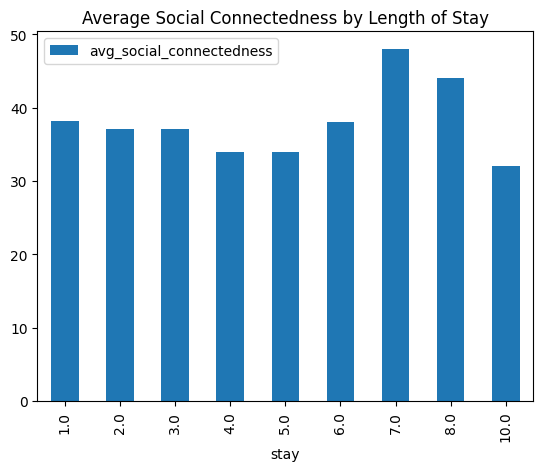

In [21]:
result.plot(x='stay', y='avg_social_connectedness', kind='bar', title='Average Social Connectedness by Length of Stay')
plt.show()

- **General Trend**: Social connectedness varies across the years with some peaks and valleys.

- **Notable Observations**: 
    - The highest social connectedness is seen at 7.0 years of stay, with a noticeable drop at 10.0 years
    - Social connectedness seems to be stable in the early years of stay (1.0 - 4.0 years) following an increase around 7.0 years.
    
- **Interpretation**: This suggests that people may feel most socially connected after several years of stay, around 7.0 years, but this connection seems to drop significantly by the 10th year. it could be hypothesized that after initial settling in, there is an increase in social bonds, but over time social networks might weaken.

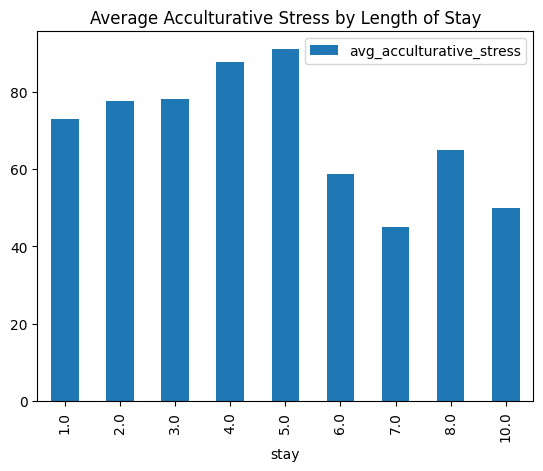

In [22]:
result.plot(x='stay', y='avg_acculturative_stress', kind='bar', title='Average Acculturative Stress by Length of Stay')
plt.show()

- **General Trend**: Acculturative stress seems to peak around 5 years of stay.
- **Noticeable Observations**:
    - There is a significant dip of acculturative stress around 6.0 years, and then a rise again at 8 years, followed by another dip at 10 years.
    - The values for 1.0 to 5.0 years of stay are generally high, suggesting more acculturative stress in the early years.
- **Interpretation**: This chart indicates stress related to adapting to new culture trends to be highest around 5.0 years of stay. The dip around 6.0 years may reflect a period of adaptation, but the stress levels seems to rise again at 7.0 years before dropping off. Acculturative stress appears to be a significant factor early on, with peaks as individuals adapt to new cultures.


### Conclusion


- **Mental Health and Length Stay**: There appears to be a relationship between the length of stay and mental health factors such as depression, social connectedness and acculturative stress. Depression seems to increase over time, social connectedness improves but can drop after longer stays and acculturative stress peaks in the early years of stay.

- These insights can help identify key periods where support systems could be reinforced, such as addressing depression in longer stays(e.g. 10 years), fostering social bond around the 7-year mark, and managing acculturative stress in the early years of stay.